<a href="https://colab.research.google.com/github/shaoyuancc/keypoint_rcnn_training_pytorch/blob/main/KeypointRCNN_training_glue_tubes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone repo
!git clone https://github.com/shaoyuancc/keypoint_rcnn_training_pytorch.git

Cloning into 'keypoint_rcnn_training_pytorch'...
remote: Enumerating objects: 430, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 430 (delta 2), reused 7 (delta 1), pack-reused 420
Receiving objects: 100% (430/430), 29.03 MiB | 35.39 MiB/s, done.
Resolving deltas: 100% (65/65), done.


Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [3]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 113 kB 8.9 MB/s 
     |████████████████████████████████| 48.3 MB 154 kB/s 
albumentations==1.2.0 is successfully installed


In [1]:
!pip install -q -U opencv-python
!echo "$(pip freeze | grep opencv-python) is successfully installed"

opencv-python==4.6.0.66
opencv-python-headless==4.6.0.66 is successfully installed


In [4]:
%cd keypoint_rcnn_training_pytorch

/content/keypoint_rcnn_training_pytorch


In [5]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [6]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [7]:
BACKUP_PATH = '/content/drive/MyDrive/bowling-path/Datasets/glue-tubes/backup'
NUM_KEYPOINTS = 2

## Augmentations

In [8]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

## Dataset class

In [9]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

## Visualising a random item from the dataset

In [10]:
def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [11]:
KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[1044.,  142., 1450.,  498.],
        [ 570.,  378.,  898.,  850.]]), 'labels': tensor([1, 1]), 'image_id': tensor([54]), 'area': tensor([144536., 154816.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[1.0920e+03, 1.8400e+02, 1.0000e+00],
         [1.4090e+03, 4.5200e+02, 1.0000e+00]],

        [[8.5600e+02, 4.2000e+02, 1.0000e+00],
         [6.3800e+02, 8.0600e+02, 1.0000e+00]]])},) 


Transformed targets:
 ({'boxes': tensor([[1044.,  142., 1450.,  498.],
        [ 570.,  378.,  898.,  850.]]), 'labels': tensor([1, 1]), 'image_id': tensor([54]), 'area': tensor([144536., 154816.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[1.0920e+03, 1.8400e+02, 1.0000e+00],
         [1.4090e+03, 4.5200e+02, 1.0000e+00]],

        [[8.5600e+02, 4.2000e+02, 1.0000e+00],
         [6.3800e+02, 8.0600e+02, 1.0000e+00]]])},)


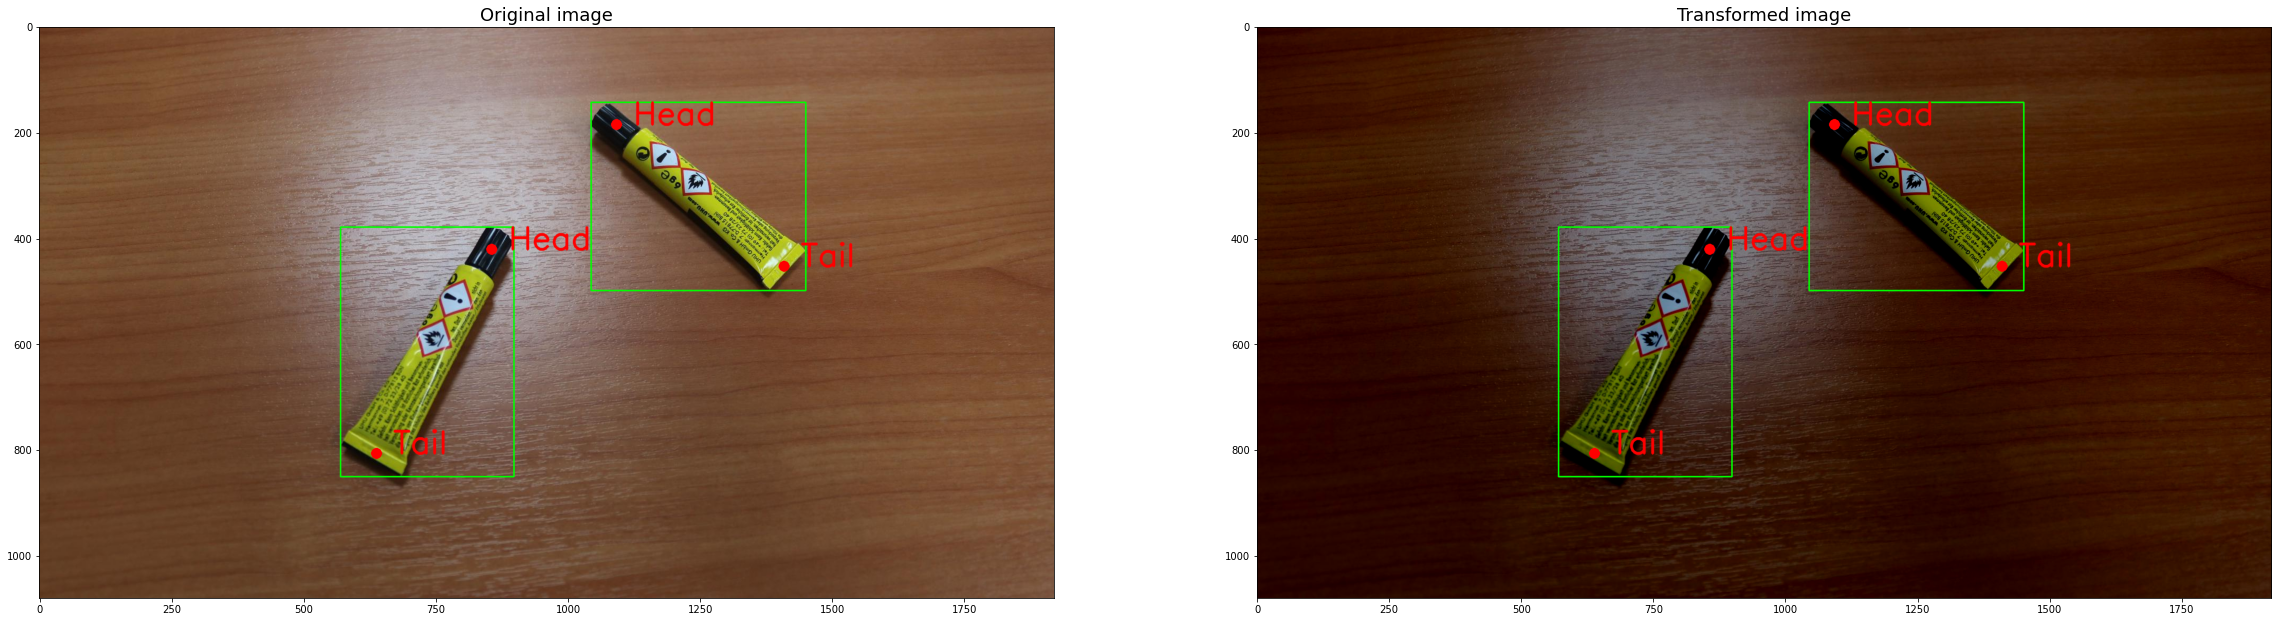

In [12]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Tail'}
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

## Drawing the loss and accuracy curves during training

In [13]:
NUM_EPOCHS = 5

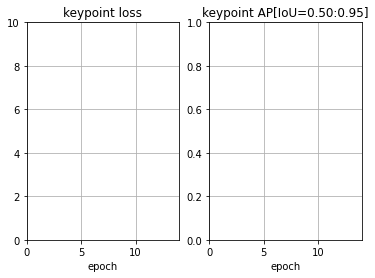

In [22]:
y_loss = {}  # loss history
y_ap = {}
y_loss['train'] = []
y_ap['val'] = []
x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="keypoint loss")
ax1 = fig.add_subplot(122, title="keypoint AP[IoU=0.50:0.95]")
ax0.grid()
ax1.grid()
ax0.set_xlim(0, NUM_EPOCHS-1)
ax1.set_xlim(0, NUM_EPOCHS-1)
ax0.set_ylim(bottom=0, top=10)
ax1.set_ylim(bottom=0)
ax0.set_xlabel('epoch')
ax1.set_xlabel('epoch')

def reset_training_plot():
    y_loss['train'].clear()
    y_ap['val'].clear()
    x_epoch.clear()

def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_ap['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join(BACKUP_PATH, 'train_performance.jpg'))

## Configuring The Training

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs/train'
KEYPOINTS_FOLDER_TEST = 'glue_tubes_keypoints_dataset_134imgs/test'

dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [16]:
def save_best_weights(model):
    torch.save(model.state_dict(), os.path.join(BACKUP_PATH, 'keypointsrnn_best_weights.pth'))
    
def save_last_checkpoint(epoch, model, optimizer, lowest_keypoint_loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lowest_keypoint_loss' : lowest_keypoint_loss
            }, os.path.join(BACKUP_PATH, 'keypointsrnn_last_checkpoint.tar'))

In [24]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

def get_config(model):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    return params, optimizer, lr_scheduler

def train_model(model, optimizer, lr_scheduler, start_epoch = 0, lowest_keypoint_loss = 100):
    print(NUM_EPOCHS, 'num epochs')
    dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
    data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
    
    reset_training_plot()
    for epoch in range(start_epoch, NUM_EPOCHS):
        metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
        keypoint_loss = metric_logger.meters['loss_keypoint'].median
        
        if (keypoint_loss < lowest_keypoint_loss):
            save_best_weights(model)
            lowest_keypoint_loss = keypoint_loss

        y_loss['train'].append(keypoint_loss)
        lr_scheduler.step()
        coco_eval = evaluate(model, data_loader_test, device)
        y_ap['val'].append(coco_eval.coco_eval['keypoints'].stats[0])
        draw_curve(epoch)

        save_last_checkpoint(epoch, model, optimizer, lowest_keypoint_loss)
    
    # Save model weights after training
    torch.save(model.state_dict(), os.path.join(BACKUP_PATH, 'keypointsrnn_final_weights.pth'))

In [18]:
# Stop run all
assert(False)

AssertionError: ignored

## Running the training

In [ ]:
model = get_model(num_keypoints = 2)
params, optimizer, lr_scheduler = get_config(model)
model.to(device)

train_model(model, optimizer, lr_scheduler)

## Restarting training after crash from last weights

In [23]:
model = get_model(num_keypoints = NUM_KEYPOINTS)
params, optimizer, lr_scheduler = get_config(model)
model.to(device)

checkpoint = torch.load(os.path.join(BACKUP_PATH, 'keypointsrnn_last_checkpoint.tar'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
lowest_keypoint_loss = checkpoint['lowest_keypoint_loss']

model.train()
print(f'Restarting training from epoch {epoch}, lowest keypoint loss so far: {lowest_keypoint_loss}')
train_model(model, optimizer, lr_scheduler, start_epoch=epoch, lowest_keypoint_loss=lowest_keypoint_loss)

Restarting training from epoch 13, lowest keypoint loss so far: 2.0501394271850586
15 num epochs
y_loss length 0, y_ap length 0, x_epoch length 0
Epoch: [13]  [ 0/37]  eta: 0:00:35  lr: 0.000300  loss: 2.4184 (2.4184)  loss_classifier: 0.0651 (0.0651)  loss_box_reg: 0.1443 (0.1443)  loss_keypoint: 2.1862 (2.1862)  loss_objectness: 0.0119 (0.0119)  loss_rpn_box_reg: 0.0109 (0.0109)  time: 0.9714  data: 0.2683  max mem: 10532
Epoch: [13]  [36/37]  eta: 0:00:01  lr: 0.000300  loss: 2.2826 (2.2736)  loss_classifier: 0.0423 (0.0476)  loss_box_reg: 0.0613 (0.0741)  loss_keypoint: 2.1523 (2.1385)  loss_objectness: 0.0041 (0.0066)  loss_rpn_box_reg: 0.0060 (0.0069)  time: 0.9868  data: 0.2429  max mem: 13049
Epoch: [13] Total time: 0:00:37 (1.0181 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:03  model_time: 0.0772 (0.0772)  evaluator_time: 0.0021 (0.0021)  time: 0.1475  data: 0.0643  max mem: 13049
Test:  [22/23]  eta: 0:00:00  model_time: 0.0823 (0.0845)  evaluator_time:

KeyboardInterrupt: ignored

## Visualise model predictions

### Using a previously saved model
Skip this section to use the model that you just trained

In [ ]:
# PATH = os.path.join(BACKUP_PATH, 'keypointsrnn_final_weights.pth')
PATH = os.path.join(BACKUP_PATH, 'keypointsrnn_best_weights.pth')
model = get_model(num_keypoints = 2, weights_path=PATH)
model.to(device)
model.eval()

### Load test data

In [25]:
iterator = iter(data_loader_test)

### Loop over the following two cells to see predictions on the test data

In [30]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

Predictions: 
 [{'boxes': tensor([[ 611.8286,  134.0268, 1129.3489,  510.1594],
        [ 768.1253,  405.4148, 1232.0675,  892.7106],
        [ 798.0817,  130.1218, 1184.2360, 1009.2185],
        [ 646.1409,  276.5699, 1010.0142,  502.2455],
        [ 671.5829,  389.5340, 1474.0608,  796.4180],
        [ 708.0942,  160.0095, 1080.6575,  389.7108],
        [ 871.5104,  443.3505, 1192.5614,  753.0132],
        [ 618.0070,  444.3270, 1298.9736,  580.3682],
        [ 724.6159,   34.7031, 1040.2782,  835.2797],
        [ 819.2249,  671.0633, 1087.9176,  876.3409],
        [ 594.7191,  502.0363, 1175.3776, 1010.0428],
        [ 258.1814,  188.8384, 1241.1614,  454.0603],
        [ 430.4044,  218.5087, 1251.0226,  788.0908],
        [ 787.7208,  563.3334, 1027.8646,  826.0392]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.9954, 0.7033, 0.2227, 0.2048, 0.2042, 0.1851, 0.1683, 0.1428,
        0.1296, 0.1142, 0.0907

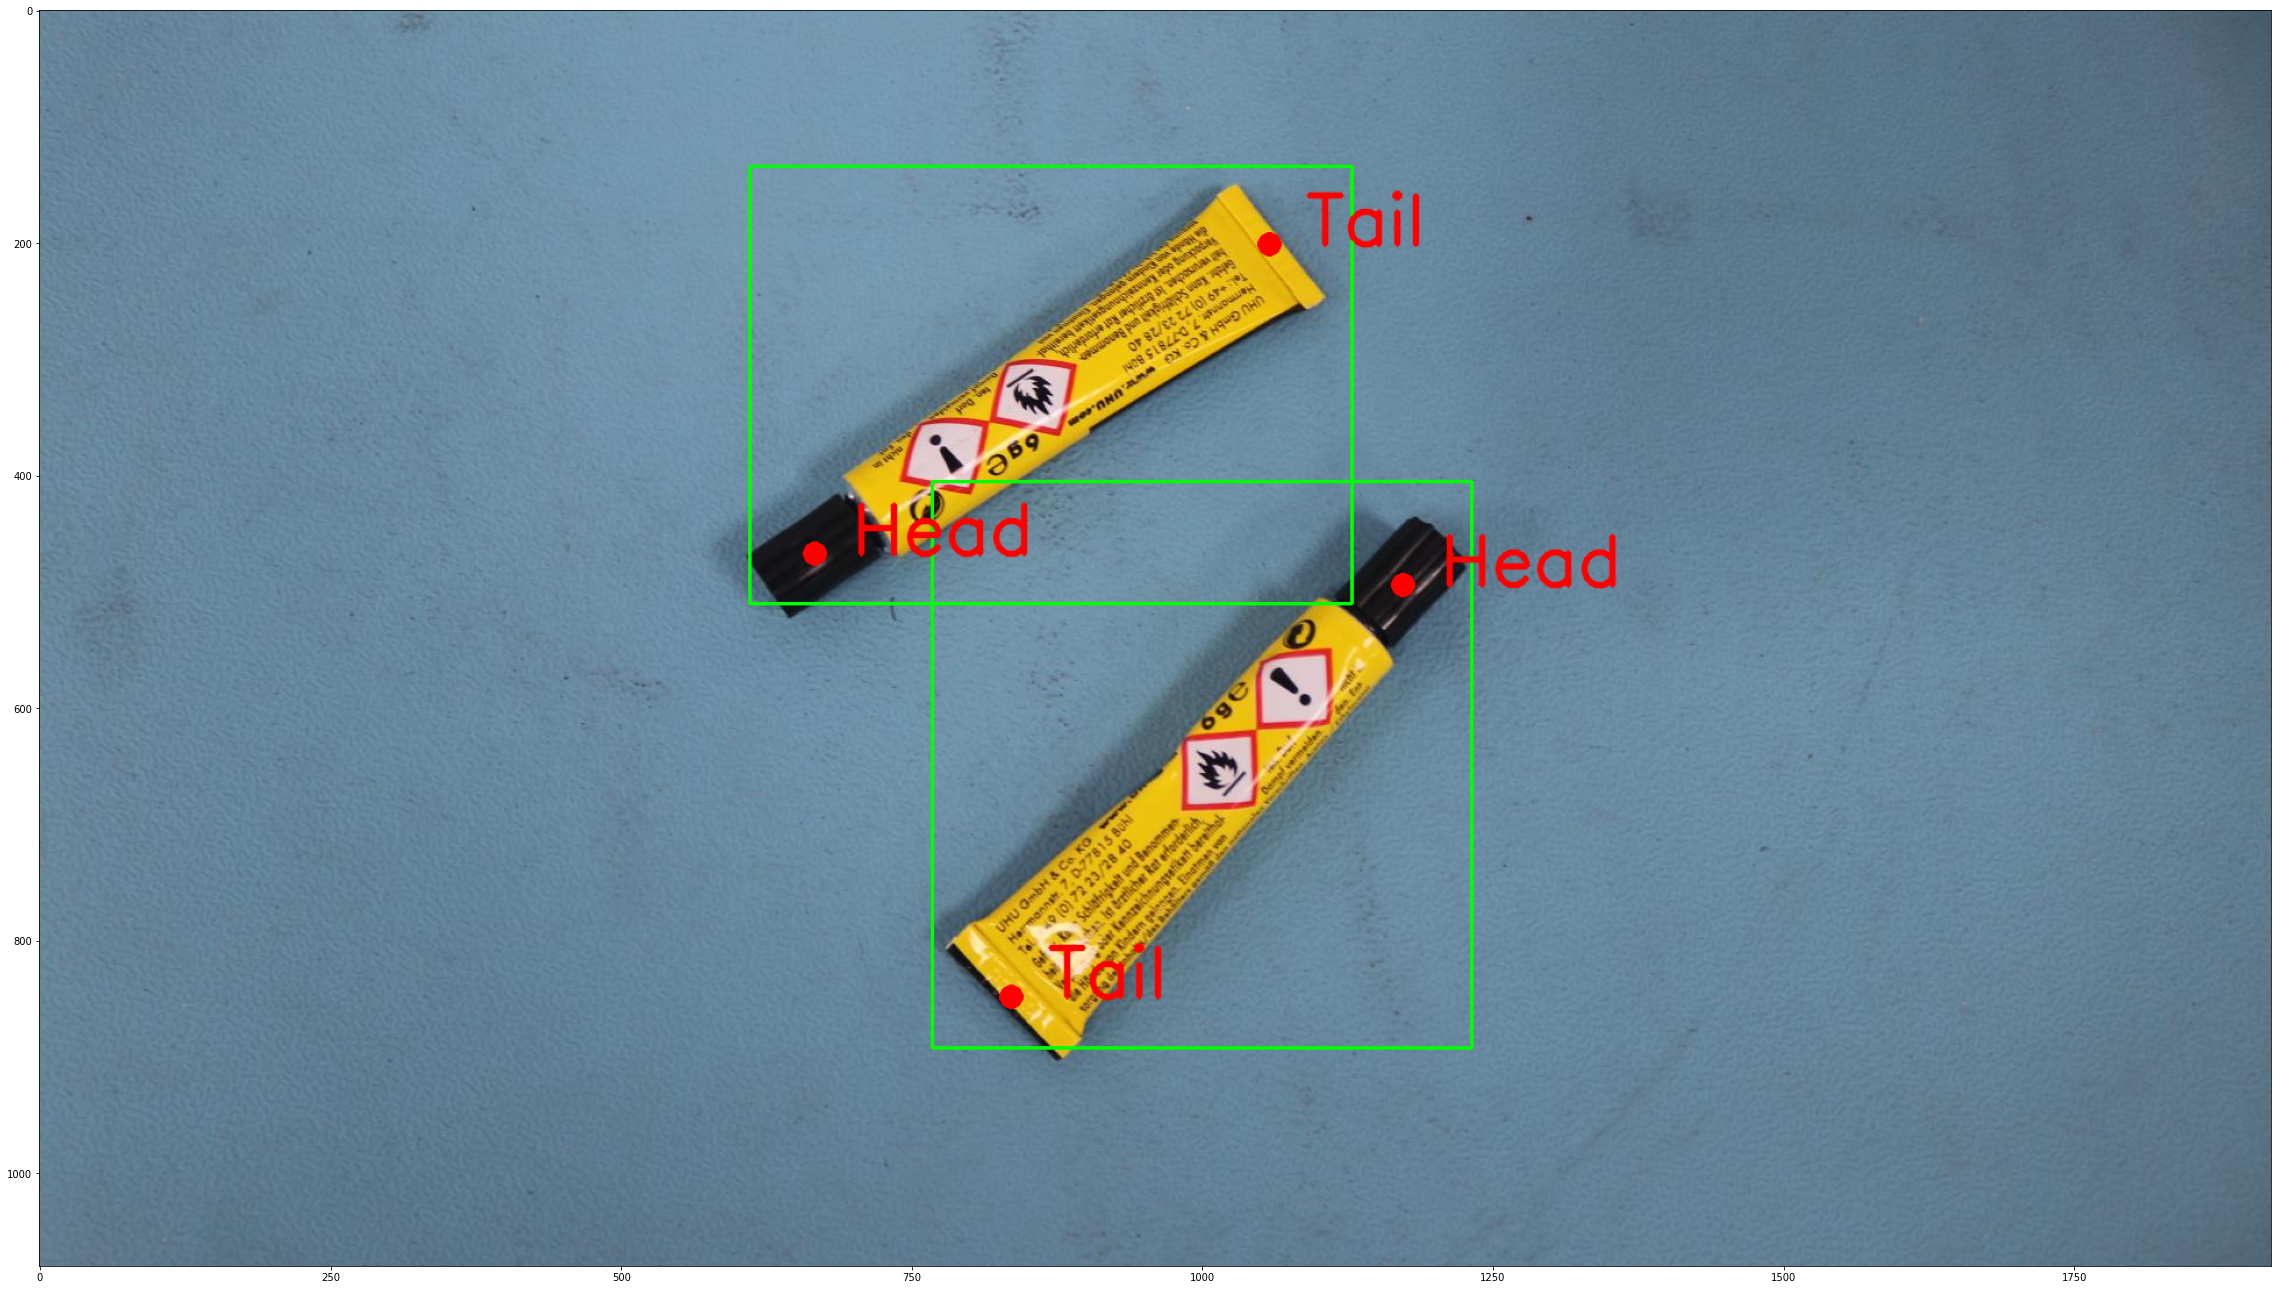

In [31]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)